In [1]:
import sys
import torch
import torch.nn as nn
import numpy as np
import torchvision
import cv2
import matplotlib.pyplot as plt
sys.path.append("../algorithms")
from nets.small_net_q import CNN_SMALL_Q
from nets.small_net_q_v2 import CNN_SMALL_Q_v2
from enviroment.full_grid_v1 import Full_Grid_V1

In [2]:
instance = 'homo_2'
grid_size = 20
input_size = 1
output_size = grid_size**2
value = True
only_q = False
env = Full_Grid_V1(grid_size, instance = instance)   

In [3]:
net = CNN_SMALL_Q_v2(grid_size, input_size, output_size, value, env.forbidden_cells, only_q=only_q, version = 1)
net.load_state_dict(torch.load(f'../algorithms/weights/full_grid/{instance}/sub{grid_size}x{grid_size}/v1/small/ddqn.pth'))

<All keys matched successfully>

In [4]:
def forward_hook(mpdule, input, output):
    activation.append(output)
def backward_hook(module, grad_in, grad_out):
    grad.append(grad_out[0])
net.conv2.register_forward_hook(forward_hook)
net.conv2.register_backward_hook(backward_hook)
target_layer = net.conv2

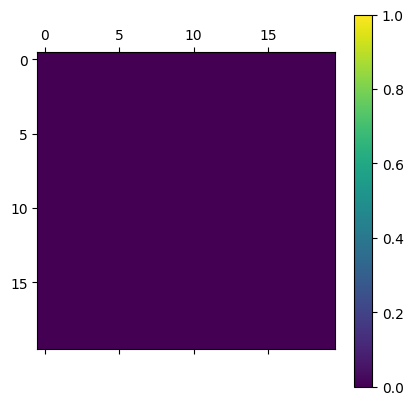

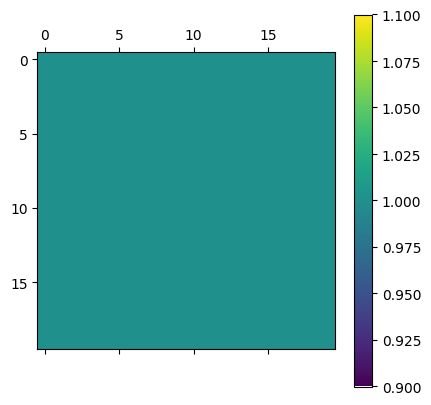

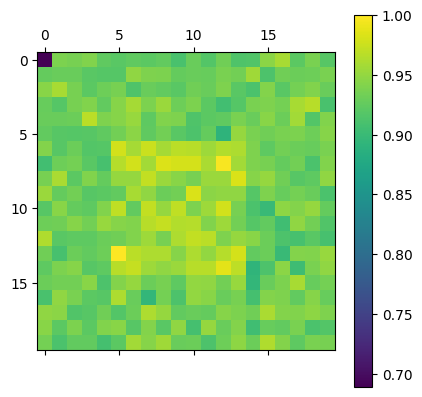

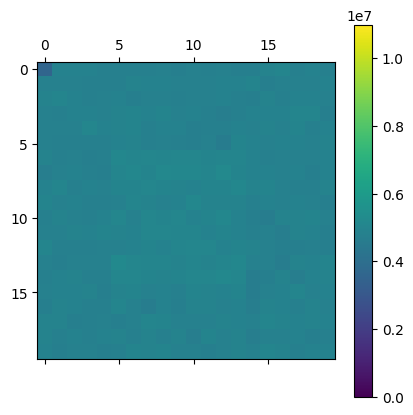

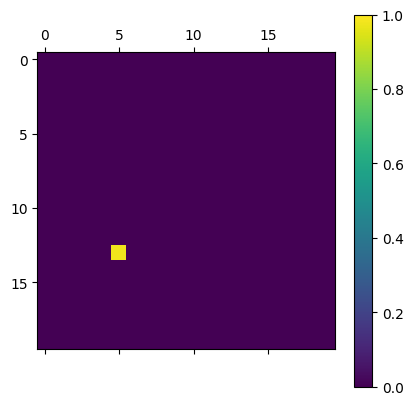

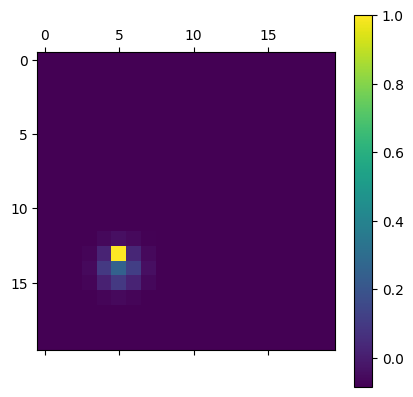

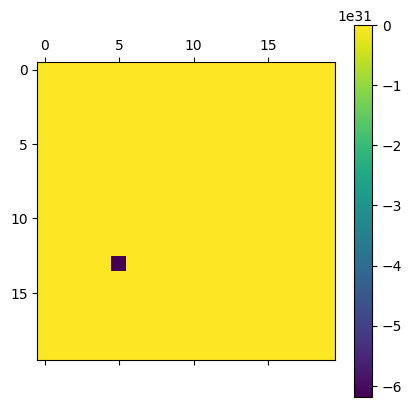

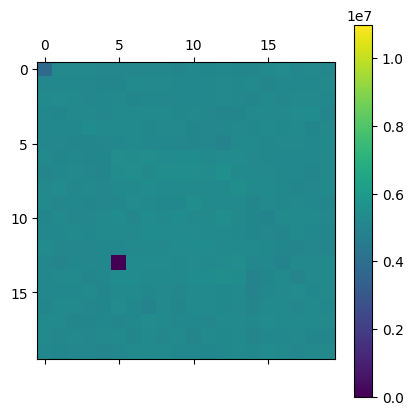

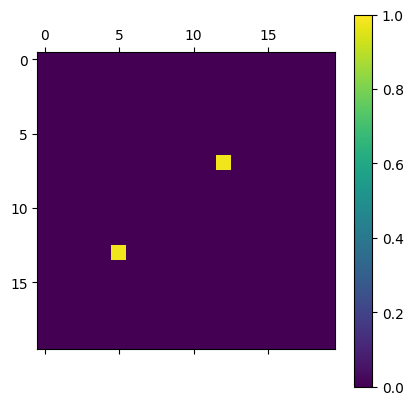

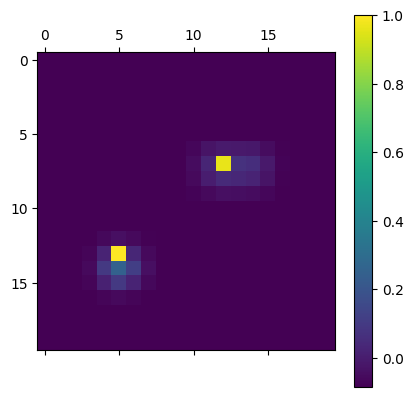

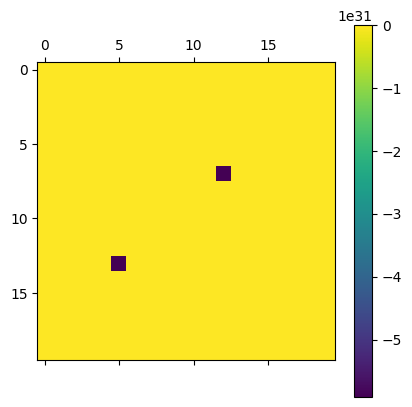

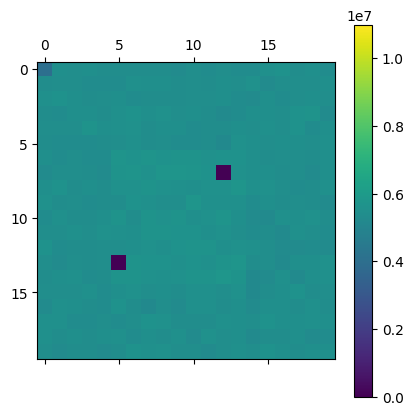

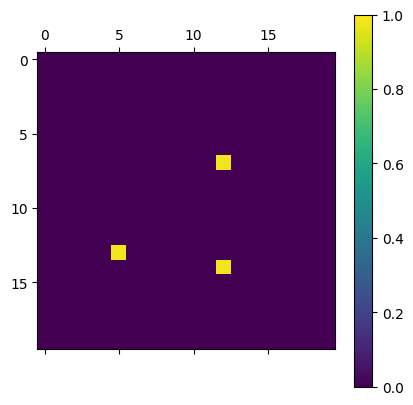

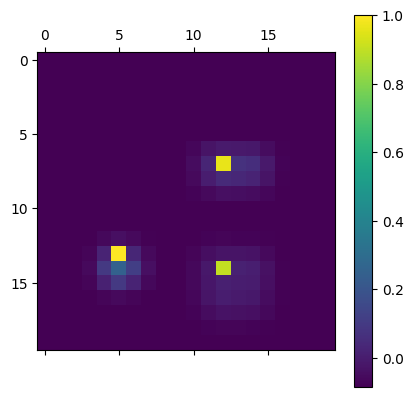

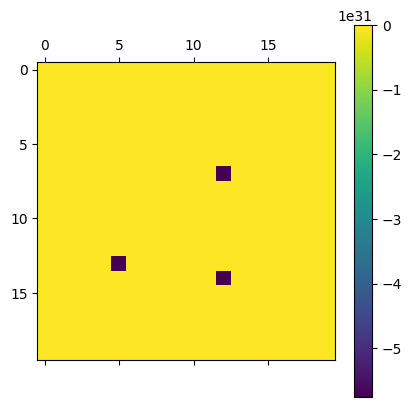

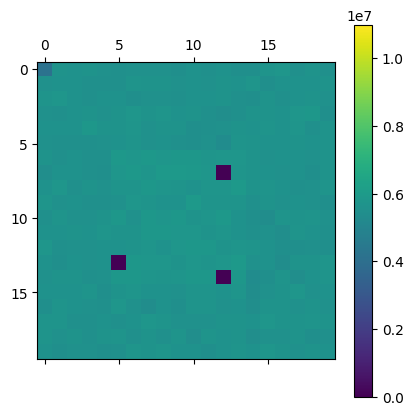

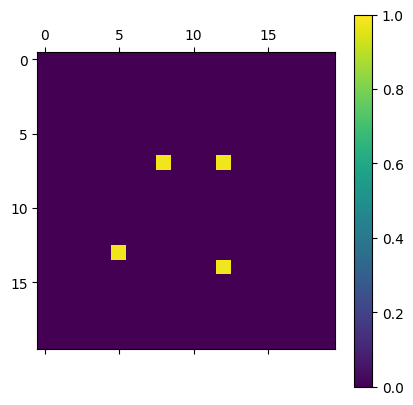

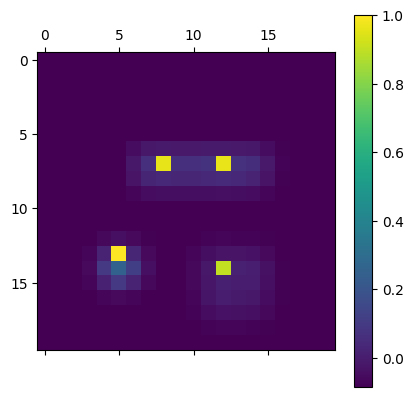

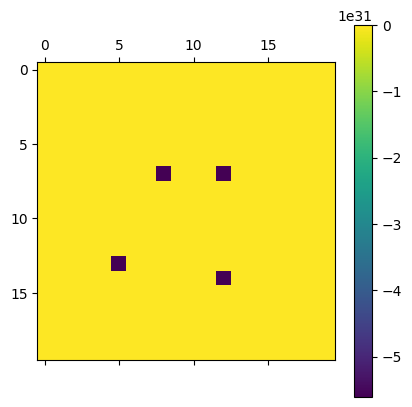

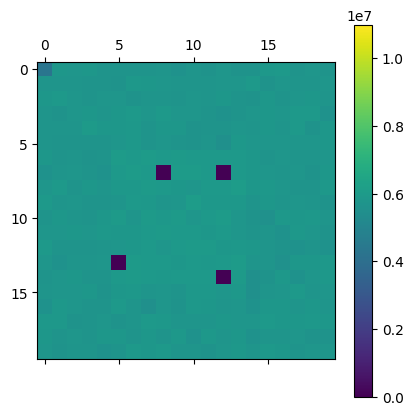

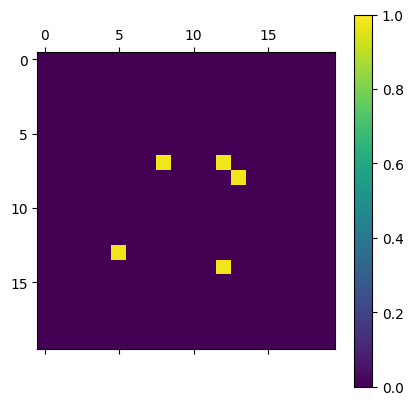

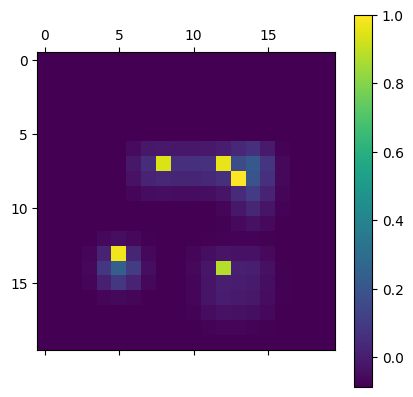

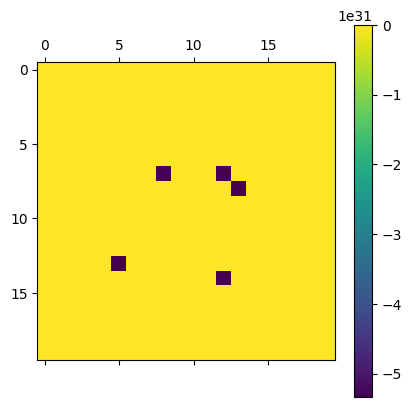

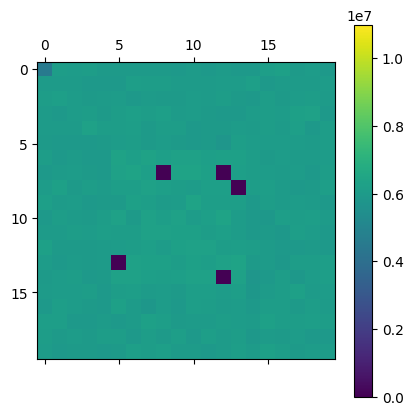

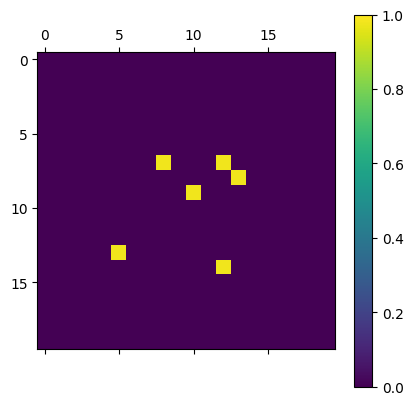

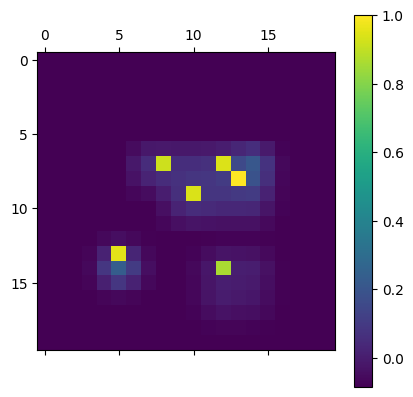

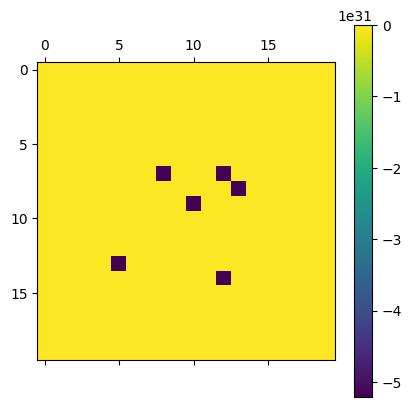

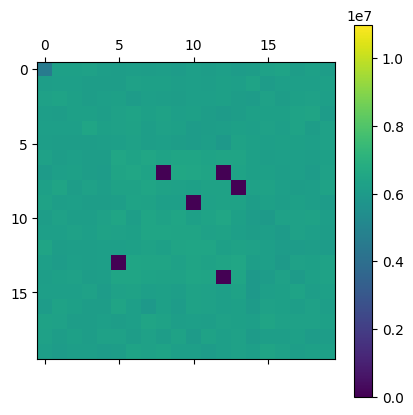

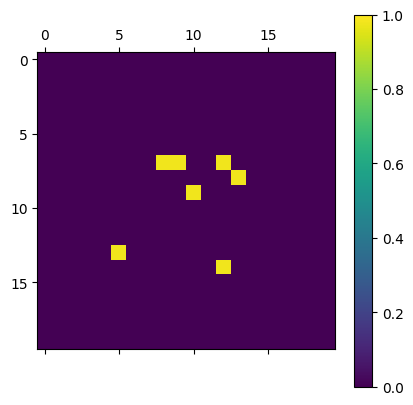

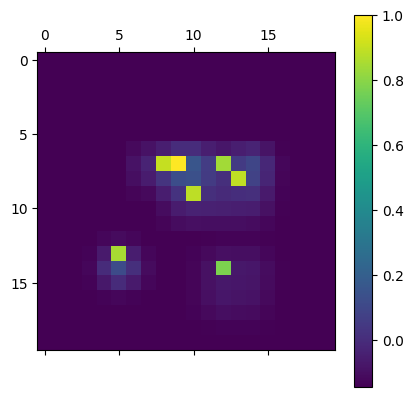

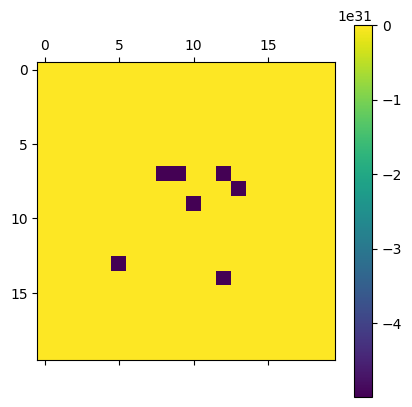

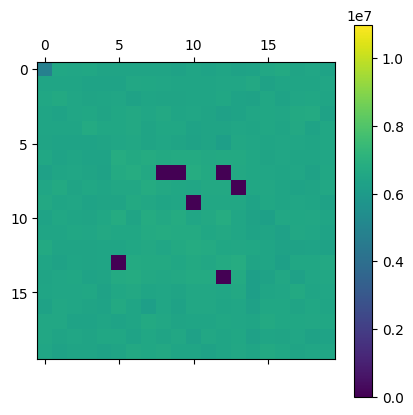

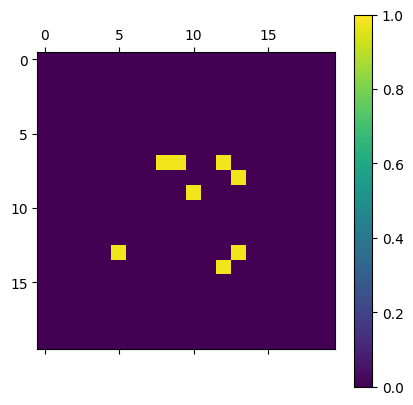

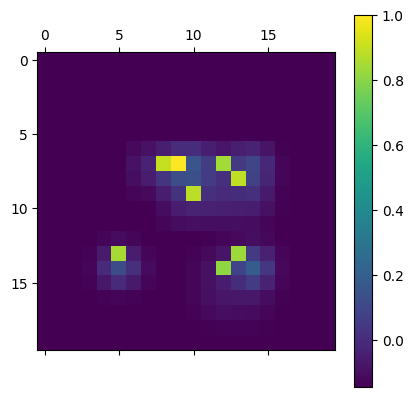

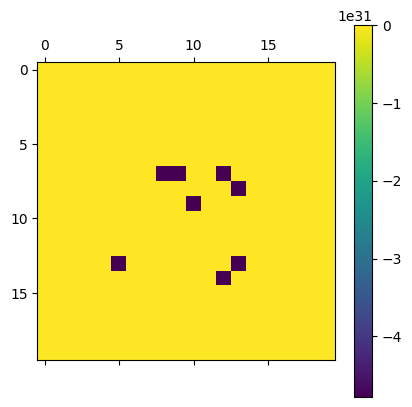

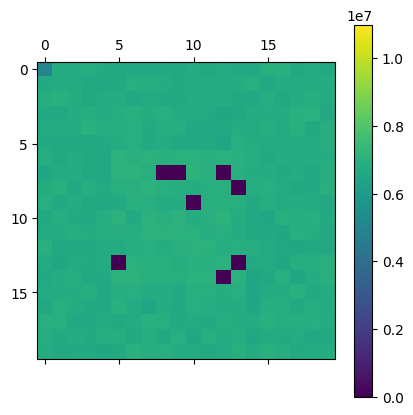

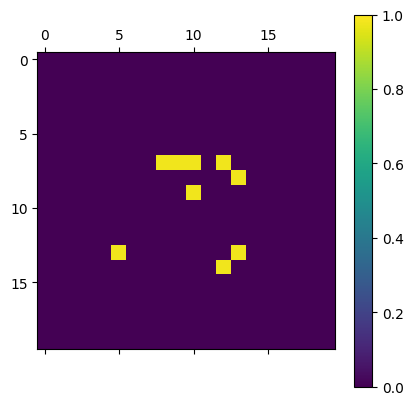

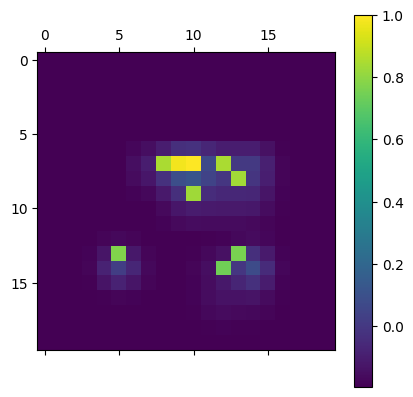

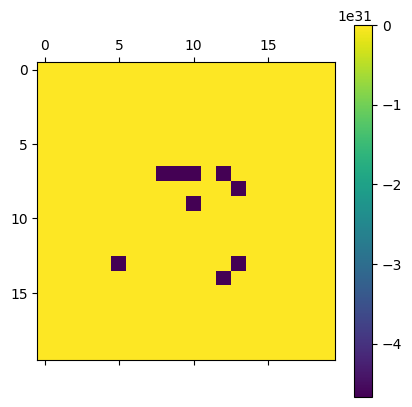

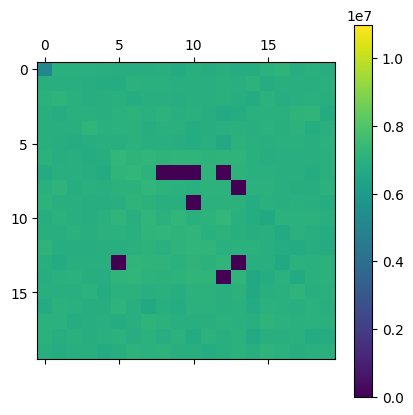

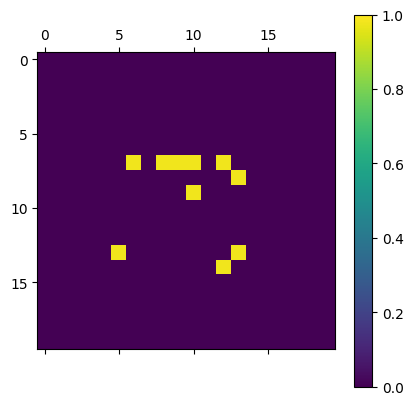

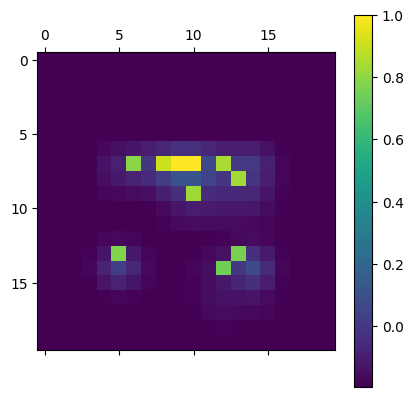

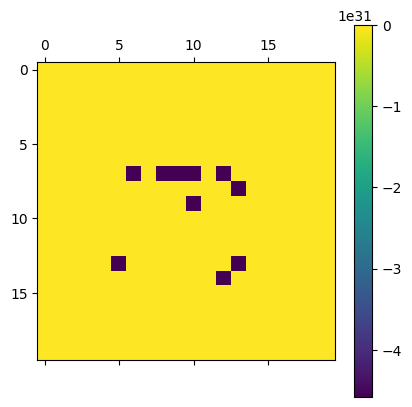

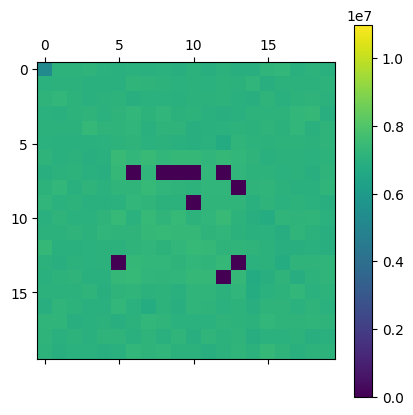

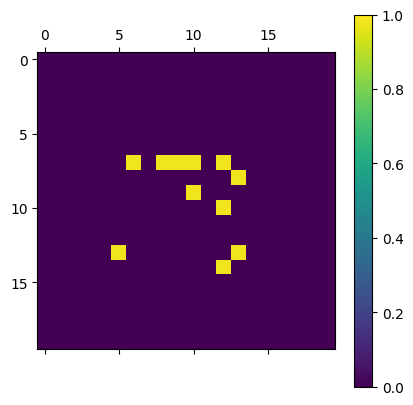

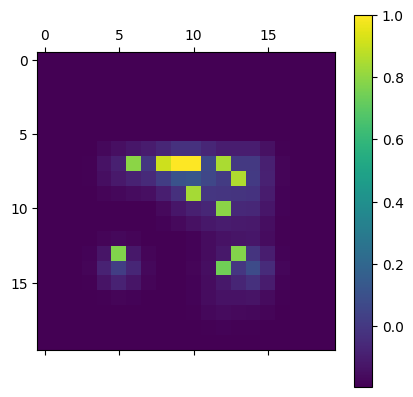

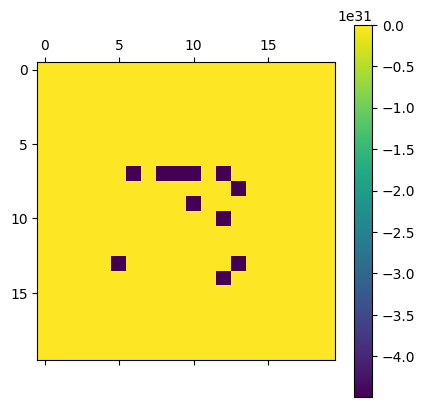

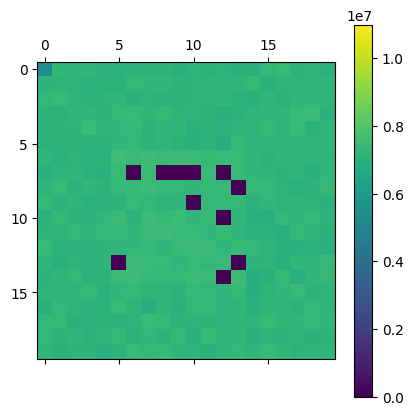

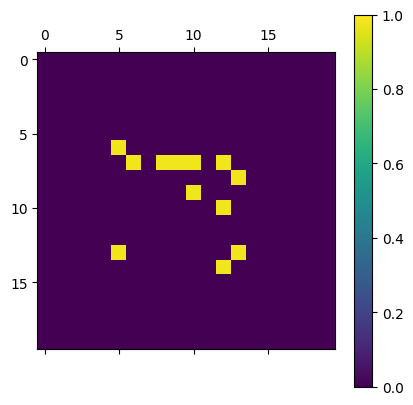

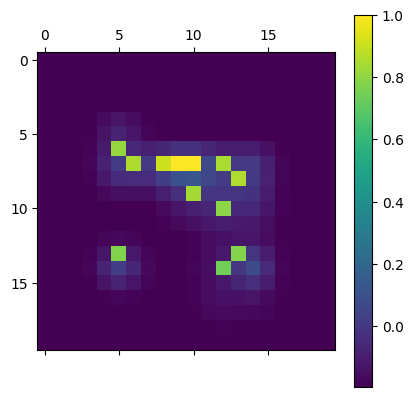

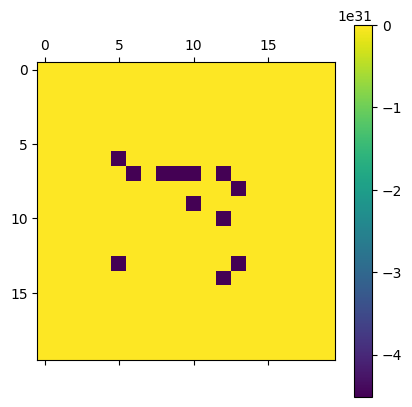

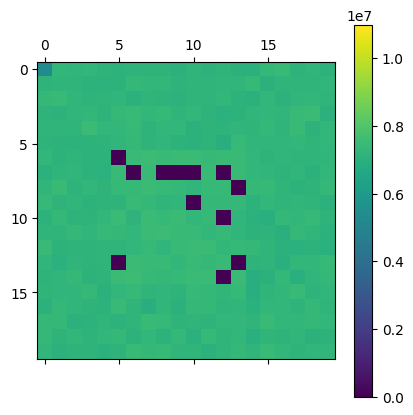

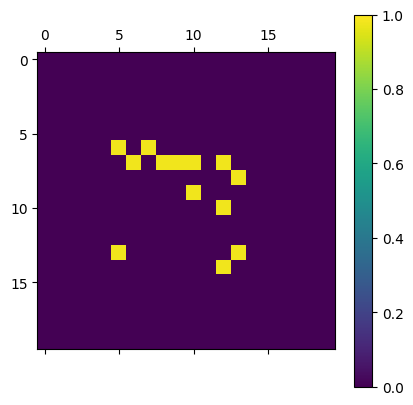

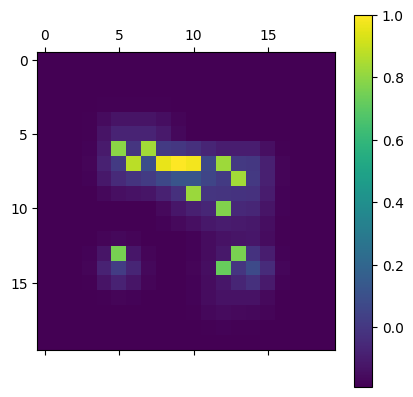

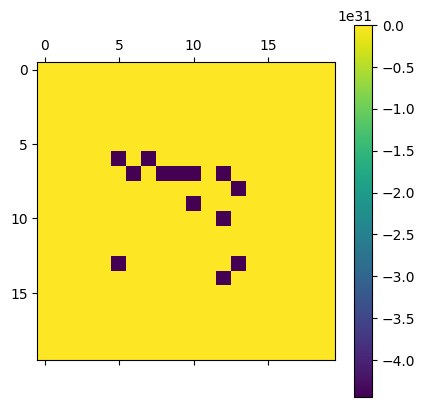

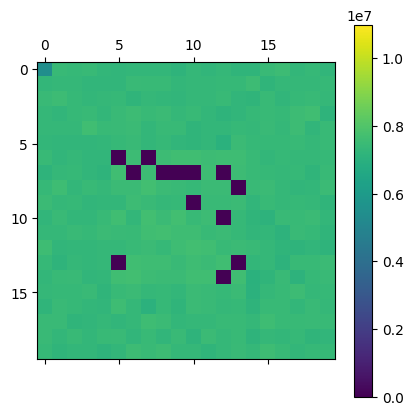

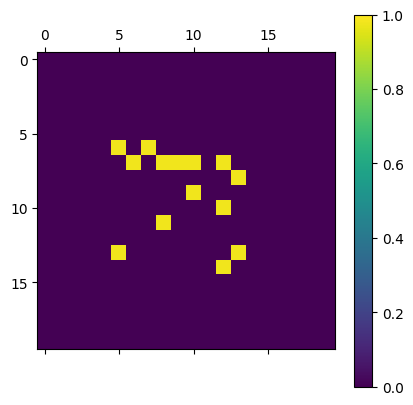

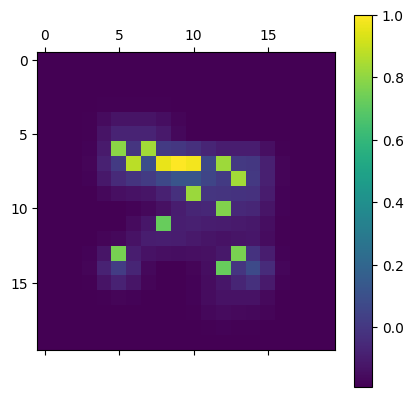

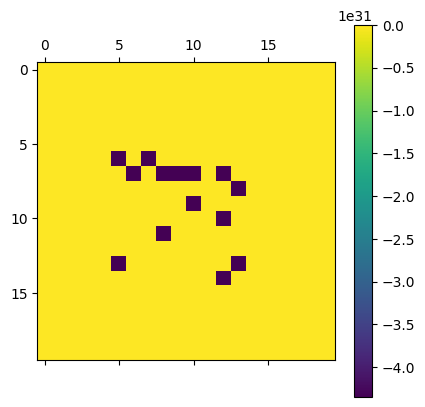

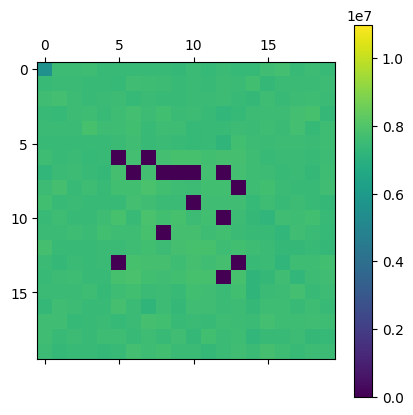

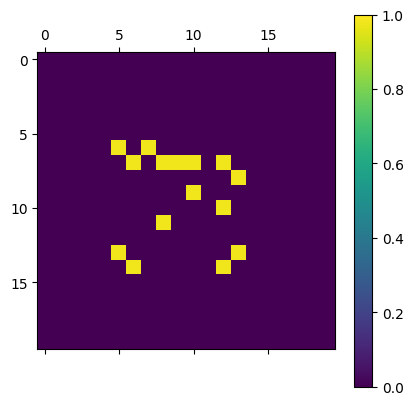

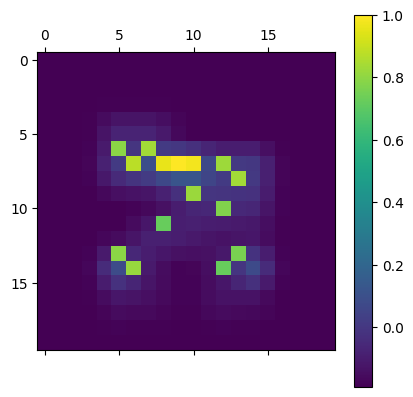

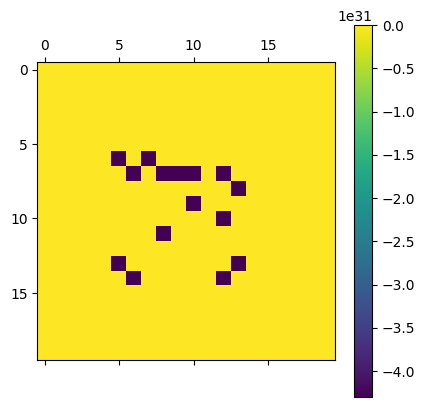

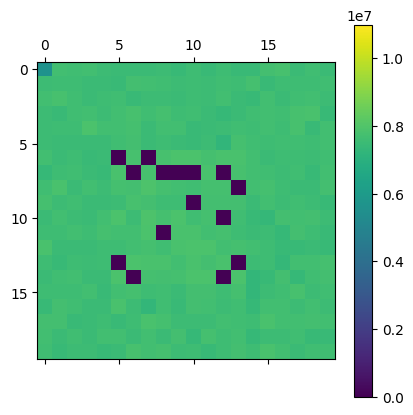

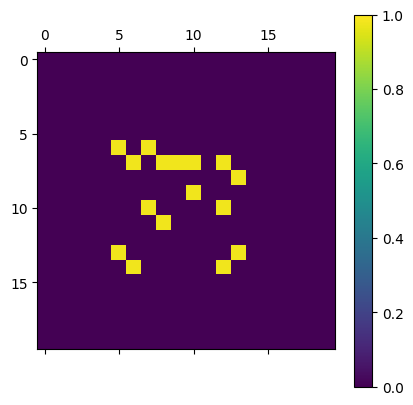

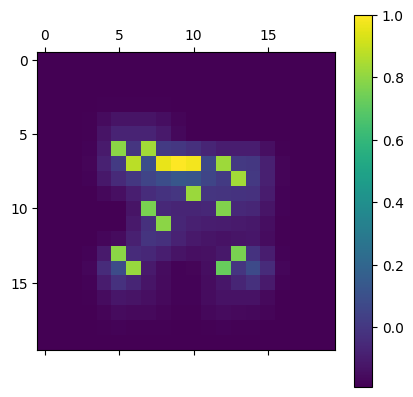

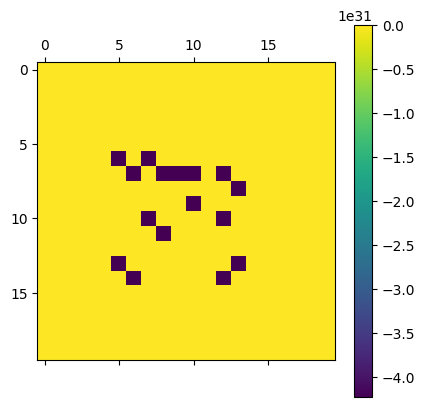

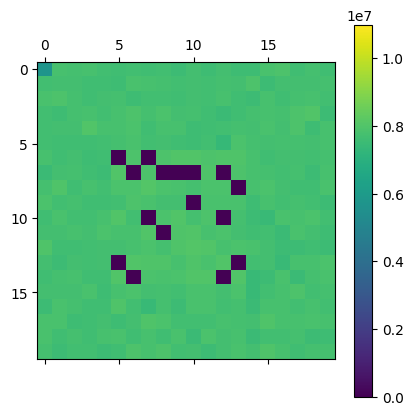

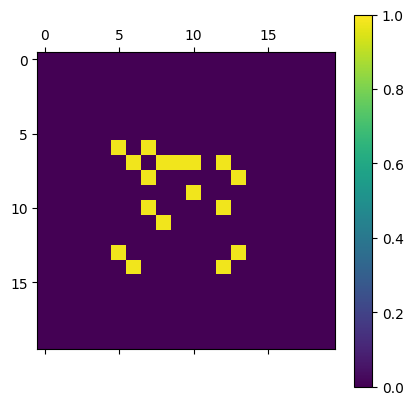

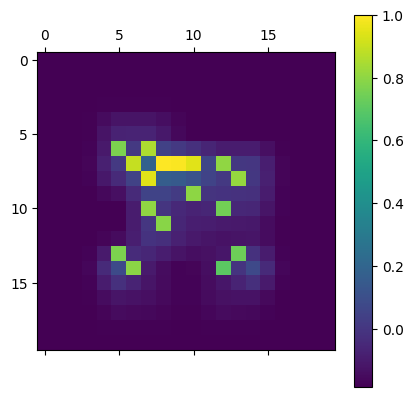

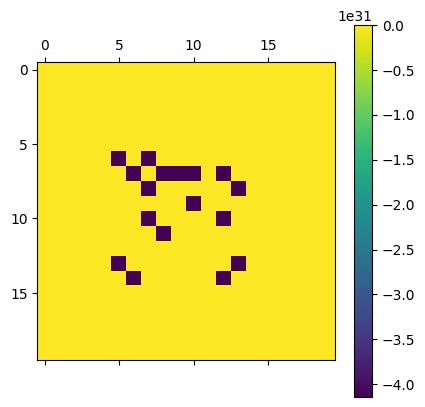

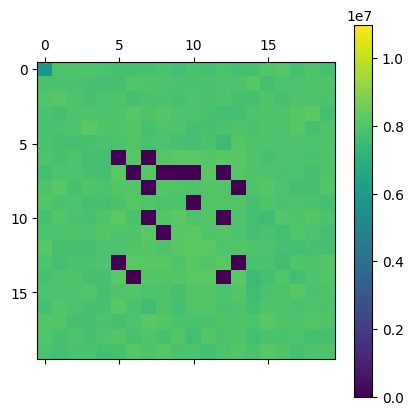

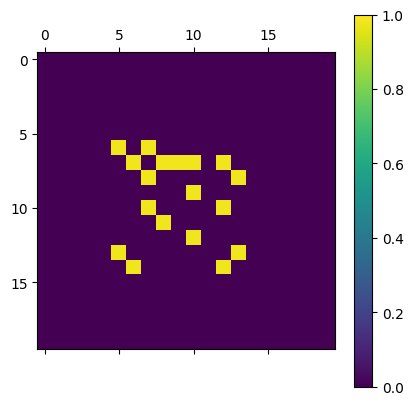

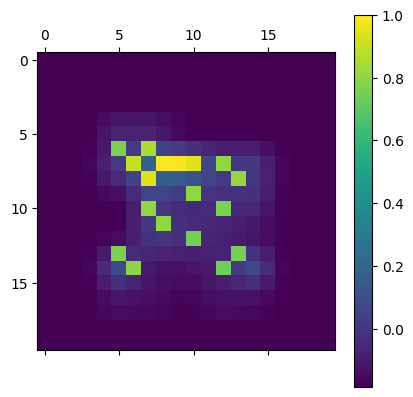

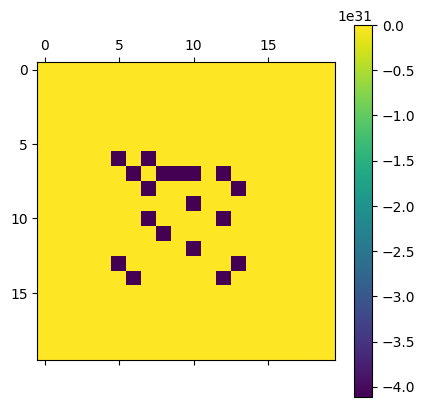

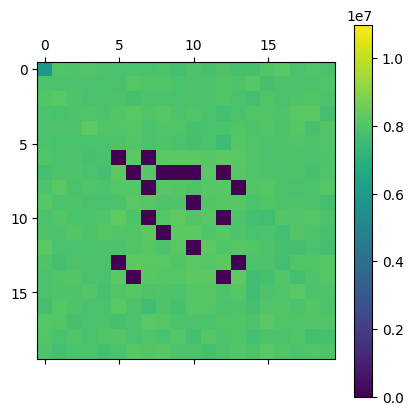

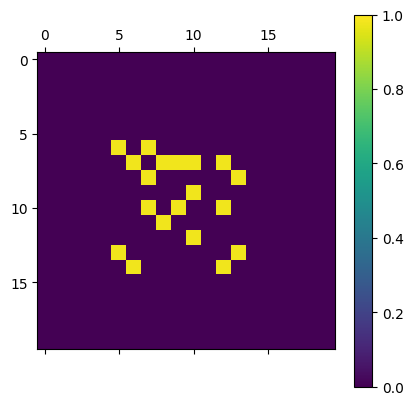

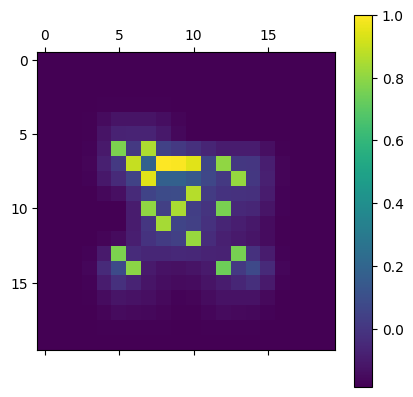

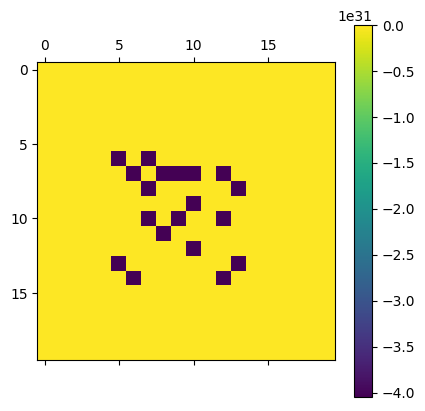

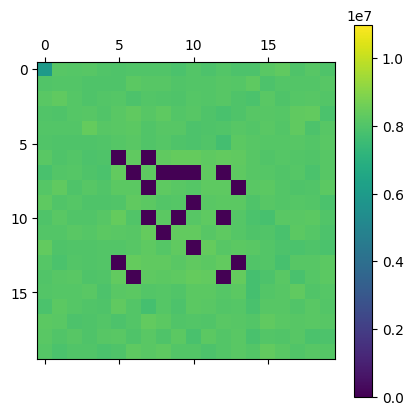

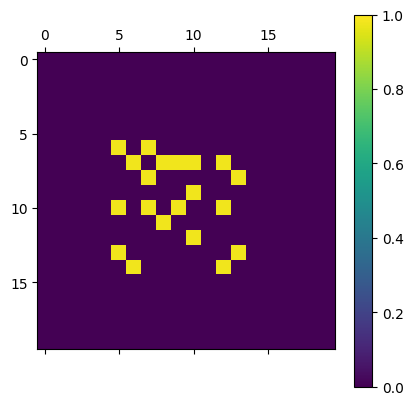

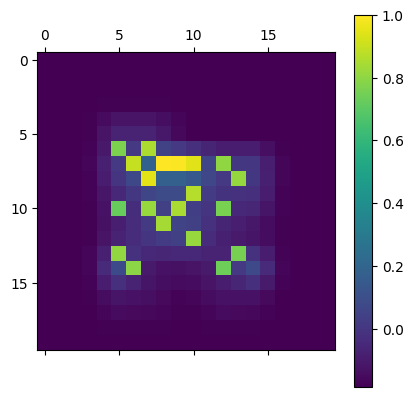

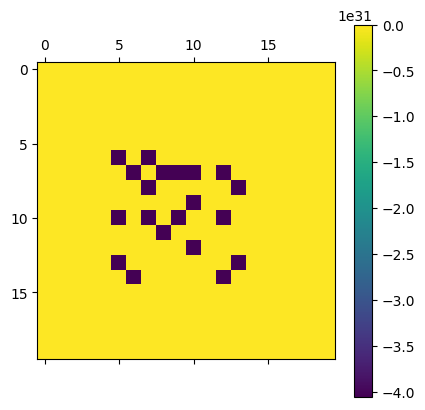

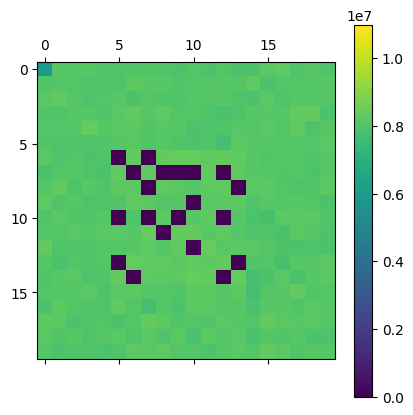

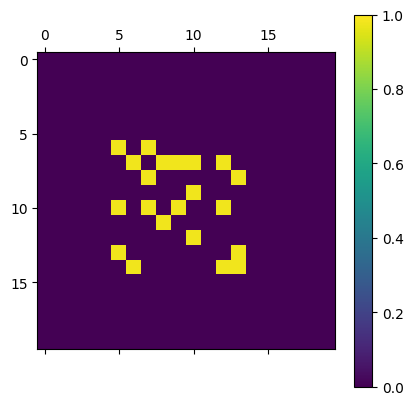

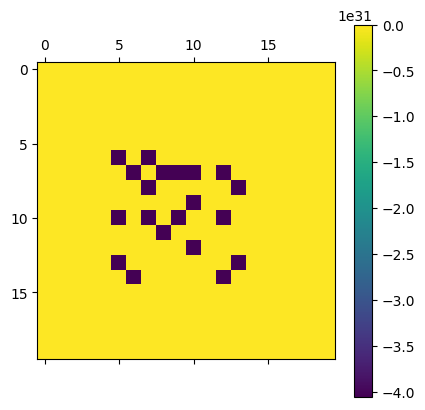

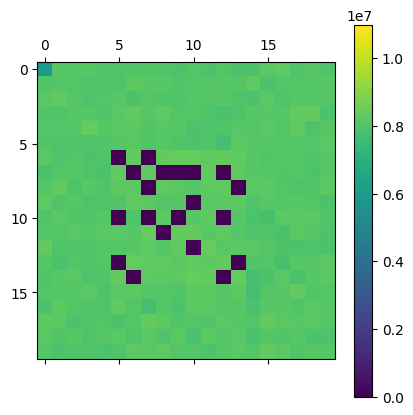

In [17]:
if grid_size == 20 and instance == "homo_1":
    v_max = 2e6 
elif grid_size == 20 and instance == "homo_2":
    v_max = 1.1e7
elif grid_size == 10 and instance == "homo_2":
    v_max = 4e6
else:
    v_max = 5e6
env.reset()
state = env._space[1].unsqueeze(0)
selected_actions = []
for i in range(env.get_episode_len()):
    grad = []
    activation = []
    q, value = net.forward(state)
    if i == 0:
        q_init = q
    selected_action = net.sample(q, state)
    loss = q[0,int(selected_action.item())]
    net.zero_grad()
    loss.backward()
    selected_actions.append(int(selected_action.item()))
    grads = grad[0].data.numpy().squeeze()
    fmap = activation[0].data.numpy().squeeze()
    tmp = grads.reshape(grads.shape[0], -1)
    weights = np.mean(tmp, axis = 1)
    cam = np.zeros(grads.shape[1:])
    for j,w in enumerate(weights):
        cam += w*fmap[j,:]
    cam = cam*(cam>0)
    heatmap = cam/np.max(cam)
    heatmap = cv2.resize(heatmap, (state.shape[1], state.shape[2]))
    heatmap = np.array(heatmap, dtype='f')
    img = state.numpy().squeeze() - 0.01980198
    superimposed_img = heatmap*0.8 -0.5 + img
    plt.matshow(img, vmin=0, vmax=1)
    plt.colorbar()
    plt.savefig(f"ddqn/grads/{instance}/sub{grid_size}x{grid_size}/action-{selected_actions[i]}_sub{grid_size}x{grid_size}_{instance}.png")
    plt.matshow(superimposed_img/superimposed_img.max())
    plt.colorbar()
    plt.savefig(f"ddqn/grads/{instance}/sub{grid_size}x{grid_size}/gradcam-{selected_actions[i]}_sub{grid_size}x{grid_size}_{instance}.png")
    _, _, _ = env.step(selected_action)
    state = env._space[1].unsqueeze(0)  
    plt.matshow((q/q.max()).reshape(grid_size, grid_size).detach().numpy())
    plt.colorbar()
    plt.savefig(f"ddqn/qs/{instance}/sub{grid_size}x{grid_size}/Q:-{selected_actions[i]}_{grid_size}x{grid_size}_{instance}.png")
    
    plt.matshow(q.reshape(grid_size, grid_size).detach().numpy(), vmin=0, vmax=v_max)
    plt.colorbar()
    plt.savefig(f"ddqn/qs-unormalized/{instance}/sub{grid_size}x{grid_size}/Q_unormalized:-{selected_actions[i]}_{grid_size}x{grid_size}_{instance}.png")
    
    
img = state.numpy().squeeze() - 0.01980198
plt.matshow(img, vmin=0, vmax=1)
plt.colorbar()
plt.savefig(f"ddqn/grads/{instance}/sub{grid_size}x{grid_size}/action_final_sub{grid_size}x{grid_size}_{instance}.png")
plt.matshow((q/q.max()).reshape(grid_size, grid_size).detach().numpy())
plt.colorbar()
plt.savefig(f"ddqn/qs/{instance}/sub{grid_size}x{grid_size}/Q:final_sub{grid_size}x{grid_size}_{instance}.png")
plt.matshow(q.reshape(grid_size, grid_size).detach().numpy(), vmin=0, vmax=v_max)
plt.colorbar()
plt.savefig(f"ddqn/qs-unormalized/{instance}/sub{grid_size}x{grid_size}/Q_unormalized:final_sub{grid_size}x{grid_size}_{instance}.png")


In [18]:
rank = list(q_init.squeeze().detach().numpy().argsort())
rank.reverse()

In [19]:
ordered_solution = np.zeros((grid_size,grid_size))
order = env.get_episode_len()
limit = env.get_episode_len()
for i in rank[:limit]:
    x, y = np.unravel_index([i], (grid_size,grid_size))
    ordered_solution[x, y] = order
    order -= 1

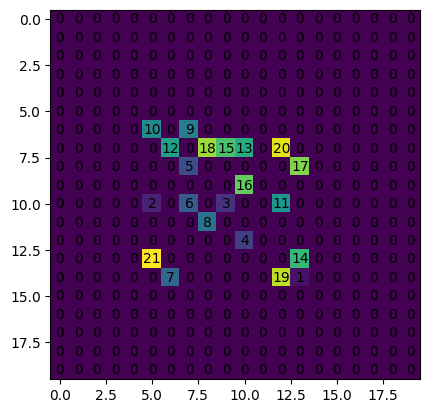

In [20]:
fig, ax = plt.subplots()
ax.imshow(ordered_solution)
for (i, j), z in np.ndenumerate(ordered_solution.astype(int)):
    ax.text(j, i, '{}'.format(z), ha='center', va='center', size=10)
plt.savefig(f"ddqn/q_rank/{instance}/sub{grid_size}x{grid_size}/initial_q_sub{grid_size}x{grid_size}_{instance}.png")